In [508]:
import os
import time
import numpy as np
import numpy.random as npr
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma

In [509]:
def log_sum_exp(vec):
    a = np.max(vec, axis=0)
    log_sum_exp = np.log(np.sum(np.exp(vec - a))) + a

    return log_sum_exp

In [134]:
with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
documents = [doc.strip().replace("\n", " ") for doc in documents]

with open("vocab.txt", "r") as file:
    vocab = [line.strip() for line in file]
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

stop_words = set(stopwords.words("english"))
corpus_matrix = []
for doc in documents:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    word_idxs = [vocab_to_idx[word] for word in filtered_tokens if word in vocab_to_idx]
    corpus_matrix.append(word_idxs)

In [472]:
def init_variational_params(corpus_matrix, K, V):
    N = len(corpus_matrix)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in corpus_matrix:
        doc = np.asarray(doc)
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    N = len(corpus_matrix)
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = 0
    for k in range(K):
        E_q_log_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_q_log_BETA

    E_q_log_THETA = 0
    for i in range(N):
        E_q_log_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j]))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    for i, doc in enumerate(tqdm(corpus_matrix, desc="Updating LAMBDA")):
        PHI_doc = PHI[i]
        for j, word in enumerate(doc):
            LAMBDA[:, word] += PHI_doc[j, :]

    ETA_matrix = np.full((K, V), ETA)
    LAMBDA = LAMBDA + ETA_matrix

    return LAMBDA, GAMMA, PHI

In [272]:
word_topic_probs = LAMBDA / LAMBDA.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-7:][::-1]
    top_words[k] = [vocab[v] for v in top_idxs]

top_words

{0: ['party', 'court', 'percent', 'police', 'gorbachev', 'states', 'two'],
 1: ['percent', 'new', 'two', 'company', 'president', 'york', 'time'],
 2: ['soviet', 'state', 'million', 'first', 'new', 'department', 'government'],
 3: ['year', 'today', 'york', 'says', 'spokesman', 'monday', 'market'],
 4: ['new', 'time', 'united', 'million', 'soviet', 'world', 'told'],
 5: ['year', 'million', 'years', 'today', 'two', 'dukakis', 'house'],
 6: ['united', 'bush', 'president', 'states', 'soviet', 'reagan', 'national'],
 7: ['percent', 'new', 'people', 'million', 'year', 'two', 'government'],
 8: ['last', 'state', 'two', 'year', 'officials', 'government', 'first'],
 9: ['party', 'united', 'defense', 'case', 'expected', 'day', 'money'],
 10: ['cdy', 'clr', 'rn', 'company', 'million', 'first', 'two'],
 11: ['percent', 'time', 'bush', 'billion', 'friday', 'police', 'million'],
 12: ['people', 'officials', 'percent', 'years', 'today', 'back', 'american'],
 13: ['new', 'year', 'national', 'friday', '

In [374]:
with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
documents = [doc.strip().replace("\n", " ") for doc in documents]
stop_words = set(stopwords.words("english"))
word_counts = Counter()
tokenized_documents = []

for doc in documents:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word \
                       not in stop_words]
    tokenized_documents.append(filtered_tokens)
    word_counts.update(filtered_tokens)

reduced_vocab = [word for word, _ in word_counts.most_common(1000)]
vocab_to_idx = {word: idx for idx, word in enumerate(reduced_vocab)}
reduced_corpus_matrix = []
for tokens in tokenized_documents:
    reduced_doc = [vocab_to_idx[word] for word in tokens if \
                   word in vocab_to_idx]
    if reduced_doc:
        reduced_corpus_matrix.append(reduced_doc)

In [510]:
def init_variational_params(corpus_mat, K, V):
    N = len(corpus_mat)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = [np.ones((len(doc), K)) / K for doc in corpus_mat]

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_mat):
    N = len(corpus_mat)
    ELBO = 0

    E_log_p_BETA = np.sum(
        (ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True)))
        )
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum(
        (ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True)))
    )
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = np.sum(
        -loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
            - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_BETA

    E_q_log_THETA = np.sum(
        -loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i, doc in enumerate(corpus_mat):
        for j, x_ij in enumerate(doc):  # x_ij is the word index
            # PHI_nonzero = PHI[i][j][PHI[i][j] > 0]
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j] + 1e-10))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_mat, K, V):
    N= len(corpus_mat)
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
    # for i in range(N):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    LAMBDA = np.full((K, V), ETA)
    for i, doc in enumerate(tqdm(corpus_mat, desc="Updating LAMBDA")):
    # for i, doc in enumerate(corpus_mat):
        doc_word_idxs = np.array(doc)
        for k in range(K):
            np.add.at(LAMBDA[k], doc_word_idxs, PHI[i][:, k])

    return LAMBDA, GAMMA, PHI

In [ ]:
K = 30
V = len(reduced_vocab)
ETA = 1 / V
ALPHA = 0.5

tol = 1e-2
iteration = 1
max_iterations = 100
curr_ELBO = 0
prev_ELBO = 301
ELBOs = []

start = time.time()
LAMBDA, GAMMA, PHI = init_variational_params(corpus_mat=reduced_corpus_matrix, K=30, V=len(reduced_vocab))
ELBOs.append(compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=reduced_corpus_matrix))
while iteration <= max_iterations:
    LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=reduced_corpus_matrix, K=30, V=len(reduced_vocab))
    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=reduced_corpus_matrix)
    print(f"Current ELBO: {curr_ELBO}")
    ELBOs.append(curr_ELBO)

    if np.abs(curr_ELBO - prev_ELBO) <= tol:
        break

    iteration += 1
    print("\n")

stop = time.time()
plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

plt.plot(np.linspace(0, float(stop-start), len(ELBOs)), ELBOs)


In [457]:
word_topic_probs = LAMBDA / LAMBDA.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-10:][::-1]
    top_words[k] = [reduced_vocab[v] for v in top_idxs]

formatted_text = "Top 10 Words for Each Topic:\n\n"
for topic, words in top_words.items():
    formatted_text += f"Topic {topic + 1}: "
    formatted_text += ", ".join(words) + "\n\n"

print(formatted_text)

Top 10 Words for Each Topic:

Topic 1: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 2: iraq, less, press, robert, points, seven, western, final, continued, car

Topic 3: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 4: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 5: travel, today, company, bad, said, northwest, lines, voted, consider, guard

Topic 6: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 7: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 8: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 9: people, first, officials, today, billion, thursday, court, party, day, say

Topic 10: students, northern, airport, september, spoke, history, feet, bad, said, northwest

Topic 11: said, would, new, one, also, year, two, million, president, government

Topic 12: said, northwest, lines, voted, conside

In [511]:
with open("vocab.txt", "r") as file:
    vocab = [line.strip() for line in file]
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
documents = [doc.strip().replace("\n", " ") for doc in documents if doc.strip()]

stop_words = set(stopwords.words("english"))
corpus_matrix = []
for doc in documents:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    word_idxs = [vocab_to_idx[word] for word in filtered_tokens if word in vocab_to_idx]
    if word_idxs:
        corpus_matrix.append(word_idxs)

In [513]:
LAMBDA, GAMMA, PHI = init_variational_params(corpus_mat=corpus_matrix, K=30, V=len(vocab))
print(compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=corpus_matrix))
LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA, GAMMA, PHI, corpus_mat=corpus_matrix, K=30, V=len(vocab))
print(compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=corpus_matrix))

-2638151.5708258115


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11112.86it/s]


-607566.882275268


In [521]:
LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA, GAMMA, PHI, corpus_mat=corpus_matrix, K=30, V=len(vocab))
print(compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=corpus_matrix))

Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11514.10it/s]


-154531.08199647604


In [ ]:
def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_mat, ALPHA=ALPHA, ETA=ETA):
    E_log_p_BETA = np.sum((ETA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))))

    E_log_p_THETA = np.sum((ALPHA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))))

    E_log_p_z_x = 0
    for i, doc in enumerate(corpus_mat):
        for j, x_ij in enumerate(doc):
            E_log_p_z_x += np.sum(
                PHI[i][j] * (
                    digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])) +
                    digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA, axis=1))
                )
            )

    E_q_log_BETA = np.sum(
        -loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) -
        np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1)
    )

    E_q_log_THETA = np.sum(
        -loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) -
        np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1)
    )

    E_log_q_z = 0
    for i, doc in enumerate(corpus_mat):
        for j, x_ij in enumerate(doc):
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j] + 1e-10))
            
    ELBO = E_log_p_BETA + E_log_p_THETA + E_log_p_z_x + E_q_log_BETA + E_q_log_THETA + E_log_q_z

    return ELBO

-5091331.693841536


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11818.66it/s]


-2671243.008299715


Initial ELBO: -5091350.056101736

Iteration: 1


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 13006.67it/s]


Current ELBO: -2674263.6112363352


Iteration: 2


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12518.76it/s]


Current ELBO: -2221000.405476545


Iteration: 3


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 10848.60it/s]


Current ELBO: -1905227.4506331466


Iteration: 4


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 8236.22it/s]


Current ELBO: -1692024.4316797014


Iteration: 5


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 10695.96it/s]


Current ELBO: -1529109.974442578


Iteration: 6


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 10529.38it/s]


Current ELBO: -1383115.770526419


Iteration: 7


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11678.50it/s]


Current ELBO: -1239111.7019053


Iteration: 8


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12446.32it/s]


Current ELBO: -1096344.1120994368


Iteration: 9


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12258.76it/s]


Current ELBO: -973000.5977260501


Iteration: 10


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12227.48it/s]


Current ELBO: -884707.8499469133


Iteration: 11


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 10025.21it/s]


Current ELBO: -838476.7768229973


Iteration: 12


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12701.87it/s]


Current ELBO: -813455.48200195


Iteration: 13


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 7987.36it/s]


Current ELBO: -795801.2234450831


Iteration: 14


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12676.05it/s]


Current ELBO: -782717.6759996956


Iteration: 15


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12040.75it/s]


Current ELBO: -773981.2529892297


Iteration: 16


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 9479.06it/s]


Current ELBO: -767875.9205972776


Iteration: 17


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11970.51it/s]


Current ELBO: -763530.5942556146


Iteration: 18


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 10232.97it/s]


Current ELBO: -760681.9529365805


Iteration: 19


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12037.35it/s]


Current ELBO: -758713.6132622471


Iteration: 20


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12728.44it/s]


Current ELBO: -757421.9658502224


Iteration: 21


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11709.61it/s]


Current ELBO: -756505.7931095375


Iteration: 22


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12275.83it/s]


Current ELBO: -755874.402144195


Iteration: 23


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 13085.26it/s]


Current ELBO: -755426.5514718874


Iteration: 24


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12055.47it/s]


Current ELBO: -755018.7838972955


Iteration: 25


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12553.31it/s]


Current ELBO: -754678.3383614301


Iteration: 26


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12619.35it/s]


Current ELBO: -754441.9475605608


Iteration: 27


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12227.16it/s]


Current ELBO: -754263.7071233409


Iteration: 28


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11911.60it/s]


Current ELBO: -754084.7611543253


Iteration: 29


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11990.36it/s]


Current ELBO: -753920.374534026


Iteration: 30


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12958.29it/s]


Current ELBO: -753818.8496032975


Iteration: 31


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12617.74it/s]


Current ELBO: -753715.7178771347


Iteration: 32


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12219.57it/s]


Current ELBO: -753564.4527099286


Iteration: 33


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12559.32it/s]


Current ELBO: -753465.2534608205


Iteration: 34


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12549.21it/s]


Current ELBO: -753381.494590922


Iteration: 35


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12687.23it/s]


Current ELBO: -753284.2413347805


Iteration: 36


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12367.87it/s]


Current ELBO: -753219.048637815


Iteration: 37


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12797.21it/s]


Current ELBO: -753164.0145703709


Iteration: 38


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12971.66it/s]


Current ELBO: -753105.0864675537


Iteration: 39


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12140.86it/s]


Current ELBO: -753059.6114039161


Iteration: 40


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11510.14it/s]


Current ELBO: -753034.7299097246


Iteration: 41


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12915.74it/s]


Current ELBO: -753008.6780812962


Iteration: 42


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 12935.11it/s]


Current ELBO: -752967.9580223253


Iteration: 43


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 10354.88it/s]


Current ELBO: -752947.7145659564


Iteration: 44


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 8869.40it/s]


Current ELBO: -752939.3164794196


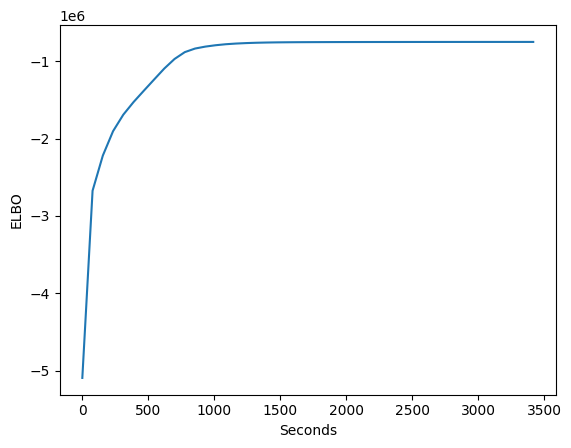

In [533]:
K = 30
V = len(vocab)
ALPHA = 0.5
ETA = 1 / V

tol = 10
iteration = 1
max_iterations = 200
curr_ELBO = 0
prev_ELBO = 301
ELBOs = []

start = time.time()
LAMBDA, GAMMA, PHI = init_variational_params(corpus_mat=corpus_matrix, K=K, V=V)
ELBOs.append(compute_ELBO(LAMBDA, GAMMA, PHI, corpus_mat=corpus_matrix))
print(f"Initial ELBO: {ELBOs[0]}\n")
while iteration <= max_iterations:
    print(f"Iteration: {iteration}")
    LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA, GAMMA, PHI, corpus_mat=corpus_matrix, K=K, V=V)
    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA, GAMMA, PHI, corpus_mat=corpus_matrix)
    print(f"Current ELBO: {curr_ELBO}")
    ELBOs.append(curr_ELBO)

    if np.abs(curr_ELBO - prev_ELBO) <= tol:
        break

    iteration += 1
    print("\n")

stop = time.time()
plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.plot(np.linspace(0, float(stop-start), len(ELBOs)), ELBOs)

In [525]:
ETA = 1 / len(vocab)
ALPHA = 0.5

corpus_mat = corpus_matrix
N = len(corpus_mat)
ELBO = 0

E_log_p_BETA = np.sum(
    (ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True)))
    )
ELBO += E_log_p_BETA

E_log_p_THETA = np.sum(
    (ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True)))
)
ELBO += E_log_p_THETA

E_log_p_z_x = 0
for i in range(N):
    M = len(corpus_mat[i])
    for j in range(M):
        x_ij = corpus_mat[i][j]
        E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
            + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
ELBO += E_log_p_z_x

E_q_log_BETA = np.sum(
    -loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
        - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1)
)
ELBO += E_q_log_BETA

E_q_log_THETA = np.sum(
    -loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
    - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1)
)
ELBO += E_q_log_THETA

E_log_q_z = 0
for i, doc in enumerate(corpus_mat):
    for j, x_ij in enumerate(doc):  # x_ij is the word index
        # PHI_nonzero = PHI[i][j][PHI[i][j] > 0]
        E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j] + 1e-10))
ELBO += E_log_q_z

E_log_p_BETA, E_log_p_THETA, E_log_p_z_x, E_q_log_BETA, E_q_log_THETA, E_log_q_z, ELBO

(np.float64(1128710596.0149217),
 np.float64(119501.09696187706),
 np.float64(-2744526.032910938),
 np.float64(-1127203632.4935842),
 np.float64(-195992.7116765848),
 np.float64(1159523.0442914483),
 np.float64(-154531.08199647604))

In [503]:
def init_variational_params(corpus_mat, K, V):
    N = len(corpus_mat)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = [np.ones((len(doc), K)) / K for doc in corpus_mat]

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_mat):
    N = len(corpus_mat)
    ELBO = 0

    E_log_p_BETA = np.sum(
        (ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True)))
        )
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum(
        (ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True)))
    )
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = np.sum(
        -loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
            - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_BETA

    E_q_log_THETA = np.sum(
        -loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i, doc in enumerate(corpus_mat):
        for j, x_ij in enumerate(doc):  # x_ij is the word index
            # PHI_nonzero = PHI[i][j][PHI[i][j] > 0]
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j] + 1e-10))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_mat, K, V):
    N = len(corpus_mat)
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
    # for i in range(N):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    LAMBDA = np.full((K, V), ETA)
    for i, doc in enumerate(tqdm(corpus_mat, desc="Updating LAMBDA")):
    # for i, doc in enumerate(corpus_mat):
        doc_word_idxs = np.array(doc)
        for k in range(K):
            np.add.at(LAMBDA[k], doc_word_idxs, PHI[i][:, k])

    return LAMBDA, GAMMA, PHI

In [501]:
def init_variational_params(corpus_matrix, K, V):
    N = len(corpus_matrix)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in corpus_matrix:
        doc = np.asarray(doc)
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    N = len(corpus_matrix)
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = 0
    for k in range(K):
        E_q_log_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_q_log_BETA

    E_q_log_THETA = 0
    for i in range(N):
        E_q_log_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j]))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    N = len(corpus_matrix)
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    LAMBDA = np.zeros((K, V))
    for i, doc in enumerate(tqdm(corpus_matrix, desc="Updating LAMBDA")):
        PHI_doc = PHI[i]
        for j, word in enumerate(doc):
            LAMBDA[:, word] += PHI_doc[j, :]

    ETA_matrix = np.full((K, V), ETA)
    LAMBDA = LAMBDA + ETA_matrix

    return LAMBDA, GAMMA, PHI

In [507]:
K = 30
V = len(vocab)
ETA = 1 / V
ALPHA = 0.5

tol = 10
iteration = 1
max_iterations = 500
curr_ELBO = 0
prev_ELBO = 301
ELBOs = []

start = time.time()
LAMBDA, GAMMA, PHI = init_variational_params(corpus_mat=corpus_matrix, K=K, V=V)
ELBOs.append(compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=corpus_matrix))
while iteration <= max_iterations:
    print(f"Iteration: {iteration}")
    LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=corpus_matrix, K=K, V=V)
    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=corpus_matrix)
    print(f"Current ELBO: {curr_ELBO}")
    ELBOs.append(curr_ELBO)

    if np.abs(curr_ELBO - prev_ELBO) <= tol:
        break

    iteration += 1
    print("\n")

stop = time.time()
plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.plot(np.linspace(0, float(stop-start), len(ELBOs)), ELBOs)

Iteration: 1


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11807.09it/s]


Current ELBO: -606434.1933255133


Iteration: 2


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 11940.86it/s]


Current ELBO: -154579.04966242798


Iteration: 3


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 8651.17it/s]


Current ELBO: 160297.01411479083


Iteration: 4


Updating PHI and GAMMA:  71%|███████   | 1588/2246 [00:08<00:03, 181.95it/s]


KeyboardInterrupt: 

In [498]:
import pandas as pd
time_iter = np.linspace(0, float(stop-start), len(ELBOs))
ELBOs = np.asarray(ELBOs)
data = {
    "time_iter": time_iter,
    "ELBO": ELBOs
}
ELBO_per_time_iter = pd.DataFrame(data=data)
ELBO_per_time_iter.to_csv("ELBO_per_time_iter.csv", index=False)

In [ ]:
time_iter = np.linspace(0, float(stop-start), len(ELBOs))
ELBOs = np.asarray(ELBOs)
data = {
    "time_iter": time_iter,
    "ELBO": ELBOs
}
ELBO_per_time_iter = pd.DataFrame(data=data)
ELBO_per_time_iter.to_csv("ELBO_V_10000.csv", index=False)

word_topic_probs = LAMBDA / LAMBDA.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-10:][::-1]
    top_words[k] = [vocab[v] for v in top_idxs]

formatted_text = "Top 10 Words for Each Topic:\n\n"
for topic, words in top_words.items():
    formatted_text += f"Topic {topic + 1}: "
    formatted_text += ", ".join(words) + "\n\n"

print(formatted_text)

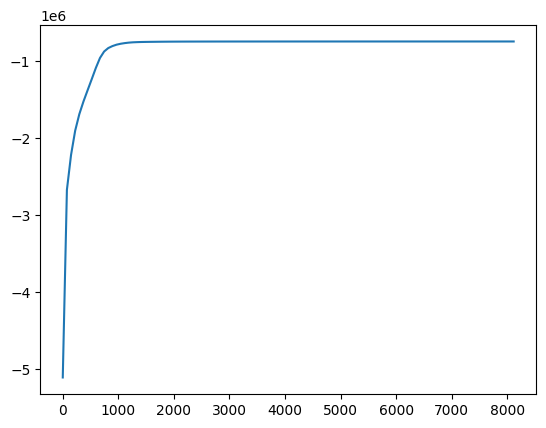

In [550]:
full_vocab_ELBOs = pd.read_csv("ELBOs_full_vocab.csv")
plt.plot(full_vocab_ELBOs["time_iter"], full_vocab_ELBOs["ELBO"])